In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
import glob
import os
from skimage.segmentation import chan_vese
import numpy as np
import PIL 
from PIL import Image 
from tensorboard.plugins.hparams import api as hp


# Display
# from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import my_functions as mf

In [3]:
from tf_explain.callbacks.grad_cam import GradCAMCallback

In [4]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [5]:
data_dir = 'datasetsSARS-COV-2 Ct-Scan'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2481 files belonging to 2 classes.
Using 1985 files for training.
Found 2481 files belonging to 2 classes.
Using 496 files for validation.


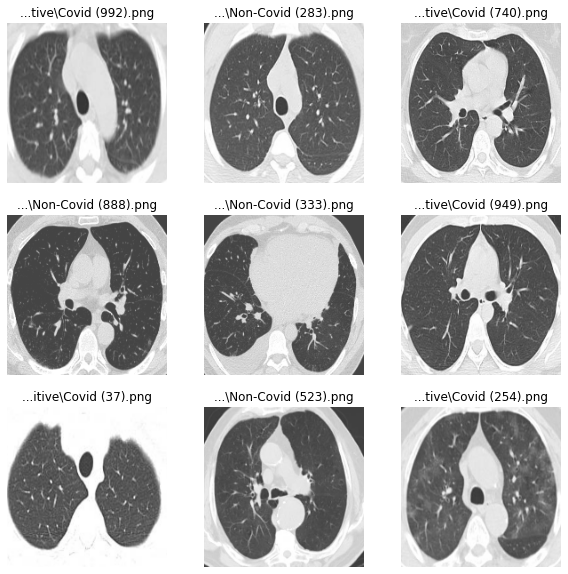

In [6]:
mf.check_dataset(train_ds)

In [7]:
inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"), 
      layers.RandomRotation(0.1)
    ]
)
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(x)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
last_layer_base_model = mf.find_last_layer(base_model)
# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(last_layer_base_model.output)

# x = keras.layers.Conv2D(
#     filters=512, 
#     # name='last_conv_layer', 
#     kernel_size=2, 
#     strides=1, 
#     activation='relu', 
#     padding="SAME")(x)

# x = keras.layers.MaxPool2D()()

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_base_model.output)

x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

base_model.trainable = False # Freeze base model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
______________________________________________________________________________________________

In [16]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('my_logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
TRAIN_DS = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
VAL_DS = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
IMAGE_PATH = "datasetsSARS-COV-2 Ct-Scan\COVID-positive\Covid (1246).png"
data = mf.get_img_array(IMAGE_PATH, image_size)

In [41]:
data.shape

(1, 180, 180, 3)

In [43]:
model.predict(data)[0][0]

0.5518095

In [54]:
model.evaluate(val_ds)

16/16 [==============================] - 2s 122ms/step - loss: 0.4575 - accuracy: 0.8085


[0.45748424530029297, 0.8084677457809448]

In [53]:
accuracy

1.0

In [55]:
def train_test_freeze(hparams):
    train_ds = TRAIN_DS
    val_ds = VAL_DS

    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True)

    run_logdir = mf.get_run_logdir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

    IMAGE_PATH = "datasetsSARS-COV-2 Ct-Scan\COVID-positive\Covid (1246).png"
    data = (mf.get_img_array(IMAGE_PATH, image_size), None)
    grd_cam_callback = GradCAMCallback(
        validation_data=data,
        class_index=0,
        output_dir=run_logdir,
    )


    epochs = 3 ## Voltar pro máximo
    base_model.trainable = False
    model.fit(
        train_ds, 
        epochs=epochs,
        batch_size=32,
        validation_data=val_ds,
        callbacks=[
            tensorboard_cb, # log metrics
            early_stopping_cb, 
            grd_cam_callback, 
            hp.KerasCallback(run_logdir, hparams)])  # log hparams])]
    
    _, accuracy = model.evaluate(val_ds)
    
    return accuracy

In [56]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_freeze(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [61]:
session_num = 3

for optimizer in HP_OPTIMIZER.domain.values:
   hparams = {
          HP_OPTIMIZER: optimizer,
   }
   run_name = "run-%d" % session_num
   print('--- Starting trial: %s' % run_name)
   print({h.name: hparams[h] for h in hparams})
   run('my_logs/hparam_tuning/' + run_name, hparams)
   session_num += 1

--- Starting trial: run-3
{'optimizer': 'adam'}
Epoch 1/3
63/63 [==============================] - 23s 224ms/step - loss: 0.5023 - accuracy: 0.7290 - val_loss: 0.4187 - val_accuracy: 0.8105
Epoch 2/3
63/63 [==============================] - 10s 156ms/step - loss: 0.4967 - accuracy: 0.7244 - val_loss: 0.4418 - val_accuracy: 0.7944
Epoch 3/3
16/16 [==============================] - 2s 109ms/step - loss: 0.4096 - accuracy: 0.8246
--- Starting trial: run-4
{'optimizer': 'sgd'}
Epoch 1/3
63/63 [==============================] - 21s 204ms/step - loss: 0.4680 - accuracy: 0.7390 - val_loss: 0.3801 - val_accuracy: 0.8266
Epoch 2/3
63/63 [==============================] - 9s 142ms/step - loss: 0.4341 - accuracy: 0.7783 - val_loss: 0.3732 - val_accuracy: 0.8367
Epoch 3/3
16/16 [==============================] - 2s 103ms/step - loss: 0.3888 - accuracy: 0.8206


In [58]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\Covid (100).png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.7890367]], dtype=float32)

In [59]:
img_path = "datasetsSARS-COV-2 Ct-Scan\\COVID-negative\\Non-Covid (100).png"
img_array = mf.get_img_array(img_path, size=image_size)
preds = model.predict(img_array)
preds

array([[0.1363592]], dtype=float32)

In [ ]:
def train_test_freeze(hparams):
    train_ds = TRAIN_DS
    val_ds = VAL_DS

    # Unfreeze the base_model. Note that it keeps running in inference mode
    # since we passed `training=False` when calling it. This means that
    # the batchnorm layers will not update their batch statistics.
    # This prevents the batchnorm layers from undoing all the training
    # we've done so far.
    base_model.trainable = True

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss=keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True)

    run_logdir = mf.get_run_logdir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

    IMAGE_PATH = "datasetsSARS-COV-2 Ct-Scan\COVID-positive\Covid (1246).png"
    data = (mf.get_img_array(IMAGE_PATH, image_size), None)
    grd_cam_callback = GradCAMCallback(
        validation_data=data,
        class_index=0,
        output_dir=run_logdir,
    )


    epochs = 100
    model.fit(
        train_ds, 
        epochs=epochs,
        batch_size=32,
        validation_data=val_ds,
        callbacks=[
            tensorboard_cb, # log metrics
            early_stopping_cb, 
            grd_cam_callback, 
            hp.KerasCallback(run_logdir, hparams)])  # log hparams])]

    _, accuracy = model.evaluate(val_ds)
    
    run_modeldir = mf.get_model_dir()
    model.save(run_modeldir)
        
    return accuracy

In [60]:
session_num = 0

for optimizer in HP_OPTIMIZER.domain.values:
   hparams = {
          HP_OPTIMIZER: optimizer,
   }
   run_name = "run-%d" % session_num
   print('--- Starting trial: %s' % run_name)
   print({h.name: hparams[h] for h in hparams})
   run('my_logs/hparam_tuning/' + run_name, hparams)
   session_num += 1

--- Starting trial: run-0
{'optimizer': 'adam'}
Epoch 1/3
63/63 [==============================] - 22s 210ms/step - loss: 0.4958 - accuracy: 0.7134 - val_loss: 0.4159 - val_accuracy: 0.8266
Epoch 2/3
63/63 [==============================] - 9s 139ms/step - loss: 0.4862 - accuracy: 0.7254 - val_loss: 0.4563 - val_accuracy: 0.7762
Epoch 3/3
 1/16 [>.............................] - ETA: 1s - loss: 0.3369 - accuracy: 0.8750

C:\Users\arthur.morais\AppData\Local\Programs\Python\Python37\lib\site-packages\tf_explain\utils\display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


16/16 [==============================] - 2s 103ms/step - loss: 0.4371 - accuracy: 0.8306
--- Starting trial: run-1
{'optimizer': 'sgd'}
Epoch 1/3
63/63 [==============================] - 20s 201ms/step - loss: 0.4891 - accuracy: 0.7249 - val_loss: 0.3974 - val_accuracy: 0.8226
Epoch 2/3
63/63 [==============================] - 8s 134ms/step - loss: 0.4945 - accuracy: 0.7149 - val_loss: 0.3936 - val_accuracy: 0.8185
Epoch 3/3
16/16 [==============================] - 2s 102ms/step - loss: 0.4066 - accuracy: 0.8226
